# Projeto Ciência de dados: Carteira de Ações com IA
- Projeto Inspiração: https://medium.com/swlh/teaching-a-machine-to-trade-stocks-like-warren-buffet-part-i-445849b208c6
- Resumo Fundamentos Empresas BR: https://fundamentus.com.br/index.php


## 1 - Importando bibliotecas

In [63]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2 - Coletando as empresas

In [64]:
def extrair_nome_arquivo(caminho_diretorio, extensao=".xls"):
    """
    Lê arquivos com uma extensão específica em um diretório, extrai uma parte do nome
    e retorna uma lista de strings com os nomes.

    Args:
        caminho_diretorio (str): Caminho do diretório onde os arquivos estão.
        extensao (str): Extensão dos arquivos a serem processados (padrão: .xls).

    Returns:
        list: Lista de strings com os nomes extraídos.
    """
    try:
        # Verifica se o diretório existe
        if not os.path.exists(caminho_diretorio):
            print(f"Diretório '{caminho_diretorio}' não encontrado.")
            return []

        # Lista os arquivos com a extensão especificada
        arquivos = [f for f in os.listdir(caminho_diretorio) if f.endswith(extensao)]

        # Processa os nomes dos arquivos
        nomes_extraidos = [arquivo.replace("balanco_", "").replace(extensao, "") for arquivo in arquivos]

        return nomes_extraidos

    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return []

In [65]:
empresas = extrair_nome_arquivo('./balancos/')

In [66]:
# fundamentos = {
#   "ABEV3": balanco_dre_abve3,
#   "empresa": balanco_dre_empresa (DataFrame),
#}

fundamentos = dict()

In [67]:
# cotacoes = {
#   "ABEV3": cotacoes_abev3,
#   "empresa": cotacoes_empresa (DataFrame),
#}

cotacoes = dict()

## 3 - Coletando os fundamentos das empresas

In [ ]:
caminho = "./balancos/"
arquivos = os.listdir(caminho)
extensao = ".xls"

for arquivo in arquivos:
    nome = arquivo.replace("balanco_", "").replace(extensao, "")
    balanco = pd.read_excel(f"{caminho}{arquivo}", sheet_name=0)
    # tornar o primeiro valor o nome da empresa
    balanco.iloc[0,0] = nome
    # tornar a primeira linha o cabeçalho
    balanco.columns = balanco.iloc[0]
    # pegar todos os valores apartir da linha 1
    balanco = balanco[1:]
    balanco = balanco.set_index(nome)
    dre = pd.read_excel(f"{caminho}{arquivo}", sheet_name=1)
    # tornar o primeiro valor o nome da empresa
    dre.iloc[0,0] = nome
    # tornar a primeira linha o cabeçalho
    dre.columns = dre.iloc[0]
    # pegar todos os valores apartir da linha 1
    dre = dre[1:]
    dre = dre.set_index(nome)
    fundamentos[nome] = pd.concat([balanco,dre])

In [69]:
cotacoes_xlsx = pd.read_excel('Cotacoes.xlsx')

## 4 - Coletando cotações das empresa

In [70]:
for empresa in cotacoes_xlsx['Empresa'].unique():
    cotacoes[empresa] = cotacoes_xlsx.loc[cotacoes_xlsx['Empresa']==empresa]

## 5 - Tratando os dados

In [71]:
print(len(empresas))
print(len(cotacoes))
print(len(fundamentos))

81
77
81


In [72]:
for empresa in empresas:
    if not (empresa in cotacoes):
        fundamentos.pop(empresa)
    elif cotacoes[empresa].isnull().values.any():
        fundamentos.pop(empresa) 
        cotacoes.pop(empresa)

In [73]:
print(len(empresas))
print(len(cotacoes))
print(len(fundamentos))

81
65
65


In [74]:
for empresa in fundamentos:
    # Corrigir as datas para o mesmo formato
    tabela = fundamentos[empresa].T
    tabela.index = pd.to_datetime(tabela.index, format="%d/%m/%Y")
    # Transformar 'Date' em index - cotacoes
    tabela_cotacao = cotacoes[empresa].set_index("Date")
    tabela_cotacao = tabela_cotacao['Adj Close']

    tabela = tabela.merge(tabela_cotacao, right_index=True, left_index=True)
    tabela.index.name = empresa

    fundamentos[empresa]= tabela

### Tratar colunas
1. Utilizar empresas que possuem as mesmas colunas
2. Ajustar colunas com nomes repetidos
3. Analisar valores vazios nas colunas

#### 5.1. Remover da análise tabelas que tem colunas diferentes

In [75]:
colunas = list(fundamentos['ABEV3'].columns)

print(len(fundamentos))

for empresa in empresas:
    if not empresa in fundamentos:
        continue
    elif set(colunas) != set(fundamentos[empresa].columns):
        fundamentos.pop(empresa)

print(len(fundamentos))

65
61


#### 5.2. Ajustar colunas com nomes repetidos

In [76]:
print(colunas)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos a Recuperar', 'Despesas Antecipadas', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas', 'Dividendos e JCP a Pagar', 'Outros', 'Provisões', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas', 'Outros', 'Tributo

In [77]:
texto_colunas = ";".join(colunas)

colunas_modificadas = []

for col in colunas:
    if colunas.count(col)==2 and col not in colunas_modificadas:
        texto_colunas = texto_colunas.replace(";"+col+";",";"+col+"_1;",1)
        colunas_modificadas.append(col)

colunas = texto_colunas.split(';')

In [78]:
for empresa in fundamentos:
    fundamentos[empresa].columns = colunas

#### 5.3. Analisar valores vazios nas colunas

In [79]:
# valores_vazios ={
#     "col0": x,
#     "col1": x+n
# }
valores_vazios = dict.fromkeys(colunas,0)
total_linhas = 0


for empresa in fundamentos:
    tabela = fundamentos[empresa]
    total_linhas += tabela.shape[0]
    for col in colunas:
        #                       quantidade valores vazios    
        valores_vazios[col] +=  pd.isnull(tabela[col]).sum()

In [ ]:
remover_colunas = []
for col in valores_vazios:
    if valores_vazios[col] > 50:
        remover_colunas.append(col)

for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
    fundamentos[empresa] = fundamentos[empresa].ffill()

### 5.4 - Criando os rótulos: Comprar, Não comprar ou Vender?

Regras:
1. Subiu mais do que o Ibovespa (ou caiu menos) -> Comprar (Valor=2)
2. Subiu menos do que o Ibovespa até o Ibovespa (2%); ou caiu mais do que o Ibovespa até Ibovespa -2% -> Não Comprar (Valor =1)
3. Subiu menos do que o Ibovespa Ibovespa; ou caiu mais do que o Ibovespa -> Vender (Valor =0)

In [81]:
dt_inicio = "2012-12-20"
dt_final = "2021-12-20"

ibov = yf.download('^BVSP',start=dt_inicio,end=dt_final)

[*********************100%***********************]  1 of 1 completed


In [ ]:
ibov_close = ibov[['Close']]

display(ibov_close)

In [ ]:
datas = fundamentos['ABEV3'].index
for dt in datas:
    if dt not in ibov_close.index:
        ibov_close.loc[dt] = np.nan

ibov_close = ibov_close.sort_index()
ibov_close = ibov_close.ffill()

ibov_close.columns = ['IBOV']

In [84]:
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].merge(ibov_close[['IBOV']], left_index=True, right_index=True)

In [85]:
# tornar indicadores em percentuais
# fundamento.trimestre % = fundamento tri / fundamento tri - 1
# cotacao.trimestre % = cotacao tri + 1 / cotacao tri


def select_default(val0, val1):
    return val0 / val1


for empresa in fundamentos:
    fundamento = fundamentos[empresa].sort_index()
    for col in fundamento:
        if "Adj Close" in col or "IBOV" in col:
            pass
        else:
            # pegar a cotação anterior
            condicoes = [
                (fundamento[col].shift(1) > 0) & (fundamento[col] < 0),
                (fundamento[col].shift(1) < 0) & (fundamento[col] > 0),
                (fundamento[col].shift(1) < 0) & (fundamento[col] < 0),
                (fundamento[col].shift(1) == 0) & (fundamento[col] > 0),
                (fundamento[col].shift(1) == 0) & (fundamento[col] < 0),
                (fundamento[col].shift(1) < 0) & (fundamento[col] == 0),
            ]
            valores = [
                -1,
                1,
                (abs(fundamento[col].shift(1))) - abs(fundamento[col]),
                1,
                -1,
                1,
            ]
            fundamento[col] = np.select(
                condicoes,
                valores,
                default=select_default(fundamento[col], fundamento[col].shift(1)),
            )
        # pegar a cotação seguinte
    fundamento["Adj Close"] = fundamento["Adj Close"].shift(-1) / fundamento["Adj Close"] - 1
    fundamento["IBOV"] = fundamento["IBOV"].shift(-1) / fundamento["IBOV"] - 1
    fundamento["Resultado"] = fundamento["Adj Close"] - fundamento["IBOV"]
    condicoes = [
        (fundamento["Resultado"] > 0),
                (fundamento["Resultado"] < 0) & (fundamento["Resultado"] > -0.02),
                (fundamento["Resultado"] < -0.02),
            ]

    valores = [2, 1, 0]

    fundamento["Decisao"] = np.select(condicoes, valores)
    fundamentos[empresa] = fundamento

In [86]:
# remover valores vazios
colunas = list(fundamentos['ABEV3'].columns)
valores_vazios = dict.fromkeys(colunas,0)
total_linhas = 0


for empresa in fundamentos:
    tabela = fundamentos[empresa]
    total_linhas += tabela.shape[0]
    for col in colunas:
        #                       quantidade valores vazios    
        valores_vazios[col] +=  pd.isnull(tabela[col]).sum()

print(valores_vazios)
print(total_linhas)

{'Ativo Total': np.int64(61), 'Ativo Circulante': np.int64(61), 'Caixa e Equivalentes de Caixa': np.int64(61), 'Aplicações Financeiras': np.int64(623), 'Contas a Receber_1': np.int64(65), 'Estoques_1': np.int64(483), 'Ativos Biológicos_1': np.int64(1874), 'Tributos a Recuperar': np.int64(266), 'Despesas Antecipadas_1': np.int64(1059), 'Outros Ativos Circulantes': np.int64(281), 'Ativo Realizável a Longo Prazo': np.int64(61), 'Aplicações Financeiras Avaliadas a Valor Justo': np.int64(1581), 'Aplicações Financeiras Avaliadas ao Custo Amortizado': np.int64(1661), 'Contas a Receber': np.int64(937), 'Estoques': np.int64(1434), 'Ativos Biológicos': np.int64(1823), 'Tributos Diferidos_1': np.int64(822), 'Despesas Antecipadas': np.int64(1130), 'Créditos com Partes Relacionadas': np.int64(1271), 'Outros Ativos Não Circulantes': np.int64(426), 'Investimentos': np.int64(345), 'Imobilizado': np.int64(62), 'Intangível': np.int64(86), 'Diferido': np.int64(2004), 'Passivo Total': np.int64(61), 'Passi

In [87]:
remover_colunas = []
for col in valores_vazios:
    if valores_vazios[col] > (total_linhas/3):
        remover_colunas.append(col)

for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
    fundamentos[empresa] = fundamentos[empresa].fillna(0)

In [88]:
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(["Adj Close", "IBOV", "Resultado"],axis=1)

In [89]:
copia_fundamentos = fundamentos.copy()

In [90]:
base_dados = pd.DataFrame()
for empresa in copia_fundamentos:
    copia_fundamentos[empresa] = copia_fundamentos[empresa][1:-1]
    copia_fundamentos[empresa] = copia_fundamentos[empresa].reset_index(drop=True)
    base_dados = pd.concat([base_dados, copia_fundamentos[empresa]])

In [ ]:
display(base_dados)

### 6. Análise Exploratória

#### 6.1. Quantidade de Respostas em cada Tipo de Decisão

In [92]:
#display(base_dados['Decisao'].value_counts())
display(base_dados['Decisao'].value_counts(normalize=True).map("{:.1%}".format))

Decisao
2    50.0%
0    43.7%
1     6.3%
Name: proportion, dtype: object

In [93]:
fig = px.histogram(base_dados, x="Decisao", color="Decisao")
fig.show()

In [94]:
# tirar a categoria 1 e transformar em 0
base_dados.loc[base_dados["Decisao"]==1, "Decisao"] = 0

In [95]:
display(base_dados['Decisao'].value_counts(normalize=True).map("{:.1%}".format))

Decisao
2    50.0%
0    50.0%
Name: proportion, dtype: object

#### 6.2. Correlação

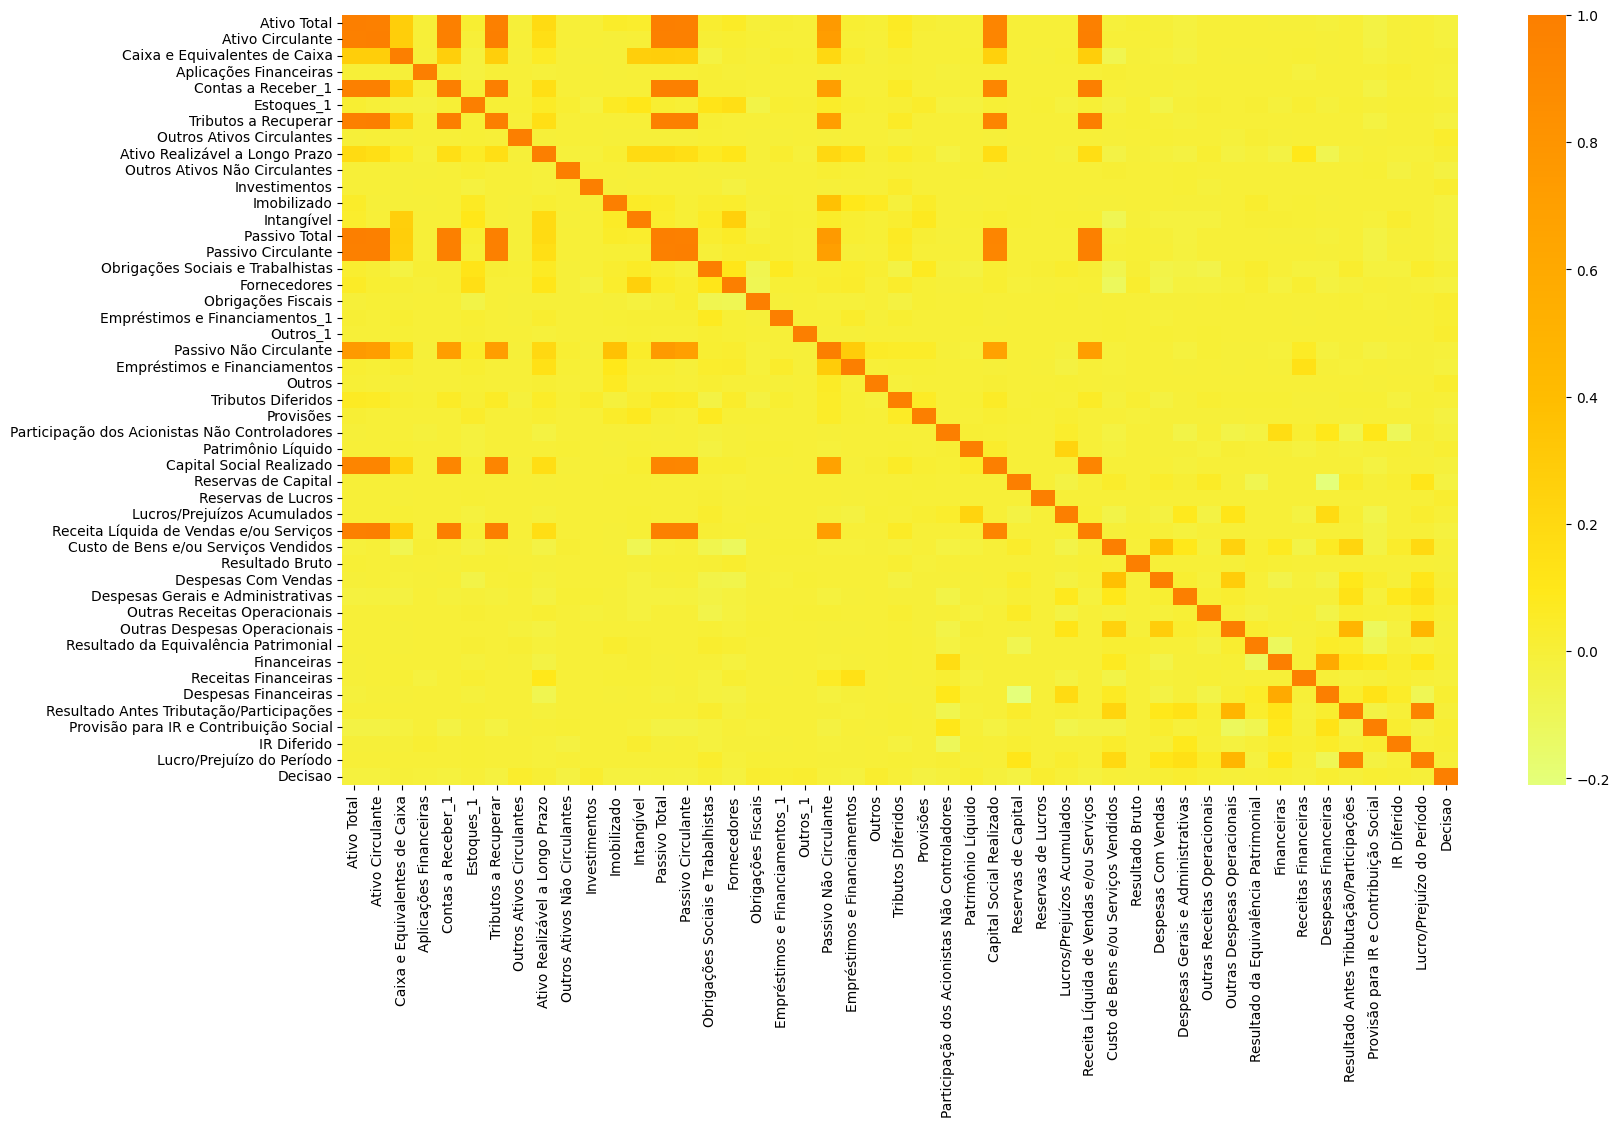

In [96]:
# remover colunas que são a mesma a informação 
correlacoes = base_dados.corr()

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
plt.show()

#### Vamos remover TODAS as Colunas "já explicadas" pelo Ativo Total

In [97]:
correlacoes_encontradas = []
correlacoes_str = str()
for col in correlacoes:
    for row in correlacoes.index:
        if row != col:
            valor = abs(correlacoes.loc[row,col])
            if valor > 0.8 and (col, row, valor) not in correlacoes_encontradas:
                correlacoes_encontradas.append((row,col,valor))
                #print(f"Correlação Encontrada: {row} {col} {valor}")
                if col == "Ativo Total":
                    correlacoes_str += f"{row};"


In [98]:
#print(correlacoes_str)

remover = correlacoes_str.split(";")
remover = remover[:-1]

#print(remover)

In [99]:
base_dados = base_dados.drop(remover,axis=1)

### 7. Feature Selection

In [100]:
from sklearn.ensemble import ExtraTreesClassifier

In [101]:
modelo = ExtraTreesClassifier(random_state=1)

X = base_dados.drop("Decisao", axis=1)
y = base_dados["Decisao"]

modelo.fit(X,y)

caracteristicas_importantes= pd.DataFrame(modelo.feature_importances_, X.columns).sort_values(by=0, ascending=False)

In [102]:
display(caracteristicas_importantes)

,0
Ativo Total,0.030934
Obrigações Fiscais,0.030533
Fornecedores,0.029732
Outros Ativos Circulantes,0.028373
Custo de Bens e/ou Serviços Vendidos,0.028206
Outros Ativos Não Circulantes,0.028041
Provisão para IR e Contribuição Social,0.027995
Tributos Diferidos,0.027246
Provisões,0.026965
Investimentos,0.026712


In [103]:
top10 = list(caracteristicas_importantes.index)[:10]

In [104]:
print(top10)

['Ativo Total', 'Obrigações Fiscais', 'Fornecedores', 'Outros Ativos Circulantes', 'Custo de Bens e/ou Serviços Vendidos', 'Outros Ativos Não Circulantes', 'Provisão para IR e Contribuição Social', 'Tributos Diferidos', 'Provisões', 'Investimentos']


#### 7.1. Aplicação do StandardScaler para melhorar o modelo

In [105]:
from sklearn.preprocessing import StandardScaler

def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    #remover target prediction
    tabela_auxiliar = tabela_original.drop("Decisao",axis=1)
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar),tabela_auxiliar.index, tabela_auxiliar.columns)

    tabela_auxiliar["Decisao"] = tabela_original["Decisao"]
    return tabela_auxiliar

In [106]:
nova_base_dados = ajustar_scaler(base_dados)

top10.append("Decisao")

nova_base_dados = nova_base_dados[top10].reset_index(drop=True)

In [107]:
display(nova_base_dados)

,Ativo Total,Obrigações Fiscais,Fornecedores,Outros Ativos Circulantes,Custo de Bens e/ou Serviços Vendidos,Outros Ativos Não Circulantes,Provisão para IR e Contribuição Social,Tributos Diferidos,Provisões,Investimentos,Decisao
0,-0.057290,-0.169845,-2.031650,-0.039535,0.050195,-0.071487,0.012364,0.028984,-0.297612,-0.026645,2
1,43.017444,-0.051947,-0.015211,-0.033323,0.050194,-0.027007,-1.562438,2.243398,-0.028001,-0.025059,0
2,-0.037799,-0.053824,0.239634,-0.032176,-0.143791,-0.023451,0.663422,0.087820,-0.031687,-0.024815,2
3,0.099897,-0.005402,0.856982,-0.032090,-2.843946,-0.023414,-1.337703,0.274441,-0.040182,-0.024637,2
4,-0.131611,-0.056927,-0.294343,-0.031913,2.782447,-0.028744,-0.097866,-0.085599,-0.026669,-0.023510,0
...,...,...,...,...,...,...,...,...,...,...,...
1877,-0.021035,-0.044456,0.293393,-0.033421,0.076757,-0.071487,0.012362,-0.093419,-0.053945,-0.025038,2
1878,-0.092771,-0.045182,-0.216244,-0.031244,0.027859,-0.071487,0.012367,0.033804,-0.046557,-0.024324,0
1879,0.334543,0.024732,0.675961,-0.031557,0.091670,-0.071487,0.012362,-0.103987,-0.026140,-0.025059,2
1880,0.165594,0.018988,0.659085,-0.031390,-0.038548,-0.071487,0.019155,0.645241,0.141015,-0.025059,0


#### 7.2 Separação dos dados em treino e teste

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
X = nova_base_dados.drop("Decisao",axis=1)
y = nova_base_dados["Decisao"]

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=1, test_size=0.8)

#### 8 - Criar comparativo e avaliação

#### Criação de um Dummy Classifier (Uma baseline para ver se o modleos são melhores do que puro chute)

In [110]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="stratified", random_state=1)

In [111]:
dummy.fit(X_train,y_train)
previsao_dummy = dummy.predict(X_val)

#### Métricas de Avaliação
- Precisão vai ser nossa métrica principal
- Recall pode ser útil, mas precisão no caso de ações é mais importante

In [112]:
def avaliar(y_val, previsao, modelo):
    print(modelo)
    report = classification_report(y_val, previsao)
    cf_matrix = pd.DataFrame(
        confusion_matrix(y_val, previsao),
        index=["Vender", "Comprar"],
        columns=["Vender", "Comprar"],
    )
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=",")
    print(report)
    plt.show()
    print("#" * 50)


Dummy
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       749
           2       0.53      0.52      0.52       757

    accuracy                           0.52      1506
   macro avg       0.52      0.52      0.52      1506
weighted avg       0.52      0.52      0.52      1506



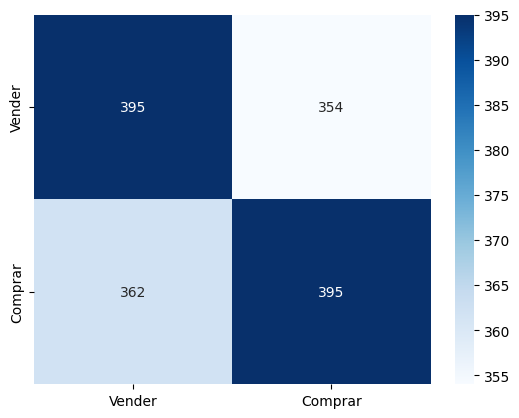

##################################################


In [113]:
avaliar(y_val,previsao_dummy,"Dummy")

#### 9 - Treinar modelos de ai

#### Modelos para testar
- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Naive Bayes
- Support Vector Machnie (SVM)
- Rede Neural

In [114]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [115]:
state=1
modelos = {
    "AdaBoost": AdaBoostClassifier(random_state=state),
    "DecisionTree": DecisionTreeClassifier(random_state=state),
    "RandomForest": RandomForestClassifier(random_state=state),
    "ExtraTree": ExtraTreesClassifier(random_state=state),
    "GradientBoost": GradientBoostingClassifier(random_state=state),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=state),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=state),
    "RedeNeural": MLPClassifier(random_state=state, max_iter=400)
}

In [ ]:
for modelo_nome in modelos:
    modelo = modelos[modelo_nome]
    modelo.fit(X_train,y_train)
    previsao = modelo.predict(X_val)
    avaliar(y_val,previsao, modelo_nome)
    modelos[modelo_nome] = modelo

#### 10 - melhorar o melhor modelo

#### Agora vamos ao tunning do modelo
- É bom sempre incluir no tunning os parâmetros "padrões" do modelo, para não piorar o treino

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

modelo_final = modelos["RandomForest"]

n_estimators = range(10, 251, 30)
max_features = list(range(2, 11, 2))
max_features.append("auto")
min_samples_split = range(2, 11, 2)

precision2_score = make_scorer(precision_score, pos_label=2)

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        "n_estimators": n_estimators,
        "max_features": max_features,
        "min_samples_split": min_samples_split,
        "random_state": [1],
    },
    scoring=precision2_score
)

In [118]:
resultado_grid = grid.fit(X_train,y_train)

RandomForest GridSearch
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       749
           2       0.53      0.52      0.52       757

    accuracy                           0.53      1506
   macro avg       0.53      0.53      0.53      1506
weighted avg       0.53      0.53      0.53      1506



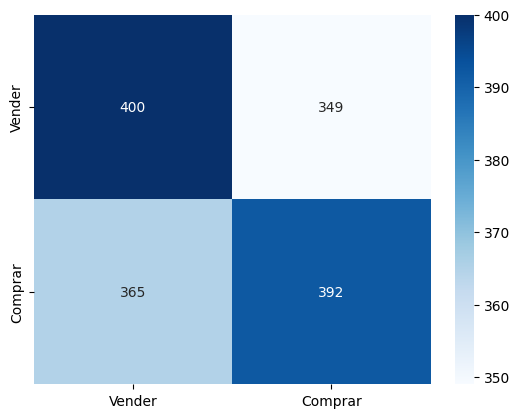

##################################################


In [119]:
modelo = resultado_grid.best_estimator_
previsao = modelo.predict(X_val)

avaliar(y_val,previsao,"RandomForest GridSearch")

#### 11 - aplicar na prática e testar resultado

#### Analisando o último trimestre de cada empresa

In [134]:
ult_tri_fund = fundamentos.copy()
ult_tri_base_dados = pd.DataFrame()
lista_empresas = []

In [135]:
for empresa in ult_tri_fund:
    lista_empresas.append(empresa)
    ult_tri_fund[empresa] = ult_tri_fund[empresa][-1:]
    ult_tri_fund[empresa] = ult_tri_fund[empresa].reset_index(drop=True)
    ult_tri_base_dados = pd.concat([ult_tri_base_dados, ult_tri_fund[empresa]])

In [136]:
ult_tri_base_dados = ult_tri_base_dados.reset_index(drop=True)
ult_tri_base_dados = ult_tri_base_dados[top10]
ult_tri_base_dados = ajustar_scaler(ult_tri_base_dados)

In [138]:
ult_tri_base_dados = ult_tri_base_dados.drop("Decisao",axis=1)

In [139]:
previsao_ult_tri = modelo.predict(ult_tri_base_dados)

In [174]:
carteira = []
carteira_inicial = []
valor_investido = 100

for i, empresa in enumerate(lista_empresas):
    if previsao_ult_tri[i] == 2:
        carteira_inicial.append(valor_investido)
        cotacao  = cotacoes[empresa]
        cotacao = cotacao.set_index("Date")
        cotacao_inicial = cotacao.loc["2020-12-31","Adj Close"]
        cotacao_final = cotacao.loc["2021-03-31","Adj Close"]
        percentual = cotacao_final / cotacao_inicial
        carteira.append(valor_investido * percentual)

In [175]:
saldo_inicial = sum(carteira_inicial)
saldo_final = sum(carteira)
print(saldo_inicial, saldo_final)
print(saldo_final/saldo_inicial)

3200 3151.986879845576
0.9849958999517425


In [177]:
variacao_ibov = ibov_close.loc['2021-03-31','IBOV'] / ibov_close.loc['2020-12-31','IBOV']
print(variacao_ibov)

0.9776038086936114


In [ ]:
#armazenar a IA

#joblib.dump(modelo, "ia_carteiraacoes.joblib")


#joblib.load("ia_carteiraacoes.joblib")